**Author: Anupriya Tripathi (a3tripat@ucsd.edu)**

In [1]:
import biom
import calour as ca
import pandas as pd
import numpy as np
import time
import seaborn as sns

#for ordering
from scipy import cluster,spatial,stats 
import skbio.diversity.alpha

The metadata field 'groups' is used to categorize the probands. 
- G1P is non-NAFLD controls; G1R first degree relatives
- G2P is NAFLD no advanced Fibrosis; G2R first degree relatives
- G3P is NAFLD-cirrhosis; G3R first degree relatives

In [2]:
#loading biom table with microal sequences and their counts
table=biom.load_table('reference-hit9k-wtax.biom')

In [3]:
#loading mapping file
mapfile=pd.read_table("all_qiime_mapping_complete_corr_CC_28_09.txt",dtype=str, sep="\t")
mapfile=mapfile.set_index("#SampleID")

In [4]:
#get all sub-OTUs
obs_arr=(table.ids('observation'))
len(obs_arr)

5709

In [5]:
#get sample ids
sample_arr=table.ids('sample')
len(sample_arr) #number of samples in the table

192

In [6]:
# number of individuals in each group
mapfile.groups.value_counts()

G1P    54
G1R    44
G3R    37
G3P    26
G2P    18
G2R    17
Name: groups, dtype: int64

In [7]:
#make a dictionary with list of samples in each group

gp_to_samples={}
gp_list = ['G1P', 'G2P', 'G3P', 'G1R', 'G2R', 'G3R']

gp_to_samples['G1P']=[idx for idx in mapfile[mapfile.groups=='G1P'].index if idx in sample_arr]
gp_to_samples['G1R']=[idx for idx in mapfile[mapfile.groups=='G1R'].index if idx in sample_arr]
gp_to_samples['G2P']=[idx for idx in mapfile[mapfile.groups=='G2P'].index if idx in sample_arr]
gp_to_samples['G2R']=[idx for idx in mapfile[mapfile.groups=='G2R'].index if idx in sample_arr]
gp_to_samples['G3P']=[idx for idx in mapfile[mapfile.groups=='G3P'].index if idx in sample_arr]
gp_to_samples['G3R']=[idx for idx in mapfile[mapfile.groups=='G3R'].index if idx in sample_arr]

In [8]:
#checking if taxonomy information is missing
count=0
for i in range(len(obs_arr)):
    if table.metadata(obs_arr[i],'observation')['taxonomy']==[]:
        count+=1
print(count)

0


In [9]:
# to store average frequencies of bacterial groups across samples in a group at each taxonomic level
t1=time.time()
gp_to_taxa={} 
for gp in gp_list:
    gp_to_taxa[gp]={}

for gp in gp_list:
    for sample in gp_to_samples[gp]:
        weighted_sampotus=np.zeros(len(obs_arr))
        sample_otu=table.data(sample,'sample',dense=True) #getting a list of frequencies of otus per sample
        otu_freqsum=np.sum(sample_otu)
        if otu_freqsum == 0:
            continue
        else:
            nz_ind=sample_otu!=0
            for i in range(len(nz_ind)):
                if nz_ind[i]:
                    weighted_sampotus[i]=sample_otu[i]/float(otu_freqsum) #normalizing freq. of an otu in sample with the sum of frequencies of all otus in the sample
                    taxa=table.metadata(obs_arr[i],'observation')['taxonomy']
                    taxa_bins=[]
                    for p in range(len(taxa)): #loop to remove unknown classification levels (eg. 's__')
                        if len(taxa[p]) <= 3:
                            taxa=taxa[:p]
                            break
                    for q in range(len(taxa)): #loop to get all the taxonomic bins that an otu falls into
                        taxa_bins.append(';'.join(taxa))
                        taxa.pop()
                    for taxa_bin in taxa_bins: #creating a dict of dict to store weights for each otu's taxa bin within each group
                        if taxa_bin not in gp_to_taxa[gp].keys():
                            gp_to_taxa[gp][taxa_bin]=weighted_sampotus[i]
                        else:
                            gp_to_taxa[gp][taxa_bin]+=weighted_sampotus[i] 
    for taxa_bin in gp_to_taxa[gp].keys():
        gp_to_taxa[gp][taxa_bin]=gp_to_taxa[gp][taxa_bin]/len(gp_to_samples[gp]) #averaging for all samples within an group
t2=time.time()
print(t2-t1)  

0.599236011505127


In [10]:
#filter taxlevel: kingdom level=0; phylum level=1 and so on
def filter_tax(gp_to_taxa, taxlevel):
    f_gp_to_taxa={}
    for gp in gp_list:
        f_gp_to_taxa[gp]={}
        for taxa in gp_to_taxa[gp].keys():
            if len(taxa.split(';'))==taxlevel+1:
                f_gp_to_taxa[gp][taxa]=gp_to_taxa[gp][taxa]
    return f_gp_to_taxa

#normalize empo levels to sum to 1
def norm(f_gp_to_taxa):
    nf_gp_to_taxa={}
    for gp in gp_list:
        nf_gp_to_taxa[gp]={}
        tot=sum(f_gp_to_taxa[gp].values())
        for taxa in f_gp_to_taxa[gp].keys():
            nf_gp_to_taxa[gp][taxa]=f_gp_to_taxa[gp][taxa]/tot
    return nf_gp_to_taxa

In [11]:
# save average frequencies at different taxonomic levels
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 1))).fillna(0).to_csv('tables/phyla_groupwise.csv', sep=',')
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 2))).fillna(0).to_csv('tables/class_groupwise.csv', sep=',')
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 3))).fillna(0).to_csv('tables/order_groupwise.csv', sep=',')
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 4))).fillna(0).to_csv('tables/family_groupwise.csv', sep=',')
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 5))).fillna(0).to_csv('tables/genus_groupwise.csv', sep=',')
pd.DataFrame.from_dict(norm(filter_tax(gp_to_taxa, 6))).fillna(0).to_csv('tables/species_groupwise.csv', sep=',')

## 1. comparing the gut microbial composition of non-NAFLD controls (G1P) vs. NAFLD without advanced fibrosis (G2P) vs. NAFLD-cirrhosis (G3P)

Only plotting top n taxa, rest in 'others'. The rationale is to represnt top taxonomic groups and keep the composition of 'others' category consistent 

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize'] = (5.0, 10.0)

In [13]:
#calculate top n taxa for a particular level
def toptaxa(nfgptaxa,numbertaxa):
    wt_tup=[]
    top_taxa=[]
    for gp in nfgptaxa: #lop to make a tupule of (wt, taxa)
        for taxa in nfgptaxa[gp].keys():
            wt_tup.append((nfgptaxa[gp][taxa],taxa))
    wt_tup=sorted(wt_tup, reverse=True)
    
    for tup in wt_tup: #getting top taxa
        if len(top_taxa)<numbertaxa and tup[1] not in top_taxa:
            top_taxa.append(tup[1])
    return top_taxa

In [14]:
#group the taxa which are not in top n taxa u 'others'
def add_others2(nfgptaxa, top_taxa):
    gp_to_taxa_rev={}
    for gp in nfgptaxa:
        gp_to_taxa_rev[gp]={}
        others=0
        for taxa in nfgptaxa[gp].keys():
            if taxa not in top_taxa:
                others+=nfgptaxa[gp][taxa]
            else:
                gp_to_taxa_rev[gp][taxa]=nfgptaxa[gp][taxa]
            gp_to_taxa_rev[gp]['others']=others
    return gp_to_taxa_rev

In [15]:
cnames = {'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides':'#4d79a8',
'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella': '#f28e2b',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus': '#e15758',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus': '#76b7b2',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia': '#edc948',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus': '#b079a2',
'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas':'#ff9da7',
'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megasphaera':'#59a14e',
'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus': '#FF00FF',
'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Catenibacterium': '#9370DB',
'others': '#bab0ac'}

In [16]:
#new plotting function that takes numbertaxa (number of taxa to be plotted i.e. top n) intead of cutoff (bottom 2% etc.) like in previous figures
def plot_gp2(gp_to_taxa, taxlevel, cnames, numbertaxa, gplist=['G1P', 'G1R', 'G2P', 'G2R', 'G3P', 'G3R'], 
             lablist = None, color='random', wide = False):
    
    fgptaxa=filter_tax(gp_to_taxa, taxlevel)
    nfgptaxa=norm(fgptaxa)
    top_taxa=toptaxa(nfgptaxa,numbertaxa)
    onfgptaxa=add_others2(nfgptaxa, top_taxa)
    onfgptaxa_df = pd.DataFrame(onfgptaxa).fillna(0)
    
    #save source
    onfgptaxa_df.to_csv('tables/source_data_fig2c.csv', sep=',')

    from scipy.cluster import hierarchy
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import pdist, squareform

    gp_list2 = gplist
    fig = plt.figure()
    
    if lablist == None:
        lablist = gplist2
    ind=np.arange(0, len(gp_list2)/2, step=0.5)
    count_ind=0
    taxa_list=[]

    #plotting barplot & legend
    ax = fig.add_subplot(1, 1, 1)
    
    
    for gp in gp_list2:
        taxa_sorted=sorted(onfgptaxa[gp].keys())
        tmp=[]
        count_tmp=0
        for taxa in taxa_sorted:
            tmp.append(onfgptaxa[gp][taxa])
            if count_tmp==0:
                bottom=0
            else:
                bottom+=tmp[count_tmp-1]
            if taxa not in taxa_list:
                taxa_list.append(taxa)
                lab=taxa
            else:
                lab=''
            if color=='random':
                p1=plt.bar(ind[count_ind],tmp[count_tmp],width=0.4, 
                           bottom=bottom, label=lab) #, color=colors_taxa[taxa])
                count_tmp+=1 
            elif color=='assigned':
                p1=plt.bar(ind[count_ind],tmp[count_tmp],width=0.4,color=cnames[taxa], bottom=bottom, label=lab) #, color=colors_taxa[taxa])
                count_tmp+=1 
        count_ind+=1 

    handles, labels = ax.get_legend_handles_labels()
    plt.ylabel('relative abundance of taxanomic group',fontsize=15)
    plt.xticks(ind, lablist, rotation=0, fontsize=15)
    plt.xticks(fontsize=18)
    plt.ylim([0,1])
    ax.set
    
    try:
        import operator
        hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
        handles2, labels2 = zip(*hl)
        ax.legend(handles2, labels2, loc='best', bbox_to_anchor=(-1, 1),fontsize=20)
    except:
        print('legend problem')
        
    return plt

### @ genus level

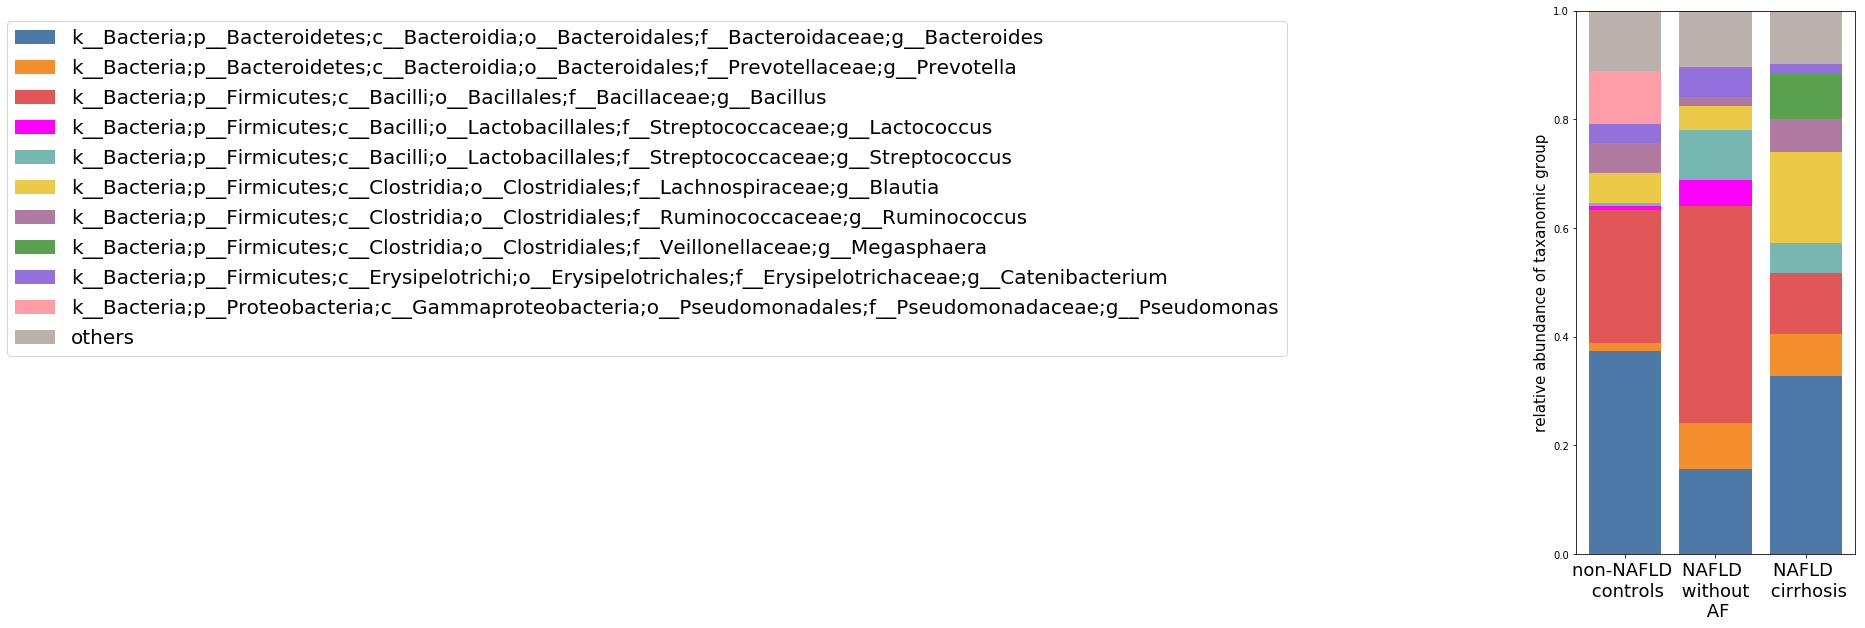

In [18]:
bar = plot_gp2(gp_to_taxa, taxlevel = 5, cnames=cnames, numbertaxa=10, gplist=['G1P', 'G2P', 'G3P'], 
              color='assigned', wide = False, 
              lablist=['non-NAFLD \n controls', 'NAFLD \n without \n AF','NAFLD \n cirrhosis'])
bar.savefig('figures/fig2c.genus_g1p_g2p_g3p_R1.pdf', bbox_to_inches='tight')

** observations from G1P vs. G3P**
- lactococcus disappears
- megasphaera appears
- increase in streptococcus
- reduced bacillus

**This analyses can be repeated for other taxonomic levels by simply changing the value of the argument 'taxlevel' in the function plot_gp2(). Kingdom=1, phylum=2, class=3 and so on**

## 2. compare microbiome correlations between related and unrelated individuals

**This analysis was done after filtering rare 16S sequences to avoid spurious correlations due to sparsity (total abundance < 10E-6 across all samples in each disease group)**

In [19]:
table=biom.load_table('reference-hit9k-wtax.biom')
tablepd = pd.read_table('reference-hit9k.txt', sep='\t', skiprows=1, index_col=0)
sample_arr = table.ids('sample')
otu_arr = table.ids('observation')

In [20]:
# make pairs of related and unrelated samples
import itertools
allposs = list(itertools.combinations(sample_arr, 2)) # all possible pairs
rel = []
unrel = []
for pair in allposs:
    if (pair[0].split('.')[-2] == pair[1].split('.')[-2]): # if sample identifiers match
        rel.append(pair)
    else:
        unrel.append(pair)

In [21]:
# print all samples in the study
print(len(sample_arr))
# print all possible pairs
print(len(allposs))
# print all related pairs
print(len(rel))
# print unrelated pairs
print(len(unrel))

192
18336
104
18232


In [22]:
# make lists of samples for correlation analysis
rp1 = [pair[0] for pair in rel]
rp2 = [pair[1] for pair in rel]

urp1 = [pair[0] for pair in unrel]
urp2 = [pair[1] for pair in unrel]

In [23]:
# for all related pairs, make a list of 'MZ twins' and 'not MZ twins'
mzp1 = []
mzp2 = []
nmzp1 = []
nmzp2 = []

for pair in rel:
    if str(mapfile.loc[pair[0], 'zygoticity']) == '1' and str(mapfile.loc[pair[1], 'zygoticity']) == '1': #to be sure
        mzp1.append(pair[0])
        mzp2.append(pair[1])
    else:
        nmzp1.append(pair[0])
        nmzp2.append(pair[1])

In [24]:
print('all related pairs: ', len(rel))
print('monozygotic twins: ', len(mzp1))
print('not monozygotic twins: ', len(nmzp1))

all related pairs:  104
monozygotic twins:  27
not monozygotic twins:  77


### 2a. correlations @ phylum level

In [25]:
from scipy.stats.stats import spearmanr  

In [26]:
# reading phyla after filtering low abundance phyla to avoid spurious correlations

table = biom.load_table('fcollapsed9k_phylum.biom')
tablepd = pd.read_table('fcollapsed9k_phylum.txt', sep='\t', skiprows=1, index_col=0)
sample_arr = table.ids('sample')
otu_arr = table.ids('observation')

In [27]:
tablepd.shape

(10, 193)

In [28]:
relcorr = []
relp = []

mzcorr = []
mzp = []

nmzcorr = []
nmzp = []

urelcorr = []
urelp=[]

for idx in tablepd.index:
    
    #overall related
    rpv1 = np.array(tablepd.loc[idx, rp1])
    rpv2 = np.array(tablepd.loc[idx, rp2])
    corr = spearmanr(rpv1, rpv2)
    relcorr.append(corr.correlation)
    relp.append(corr.pvalue)
    
    #monozygotic
    mzv1 = np.array(tablepd.loc[idx, mzp1])
    mzv2 = np.array(tablepd.loc[idx, mzp2])
    corr = spearmanr(mzv1, mzv2)
    mzcorr.append(corr.correlation)
    mzp.append(corr.pvalue)
    
    #dizygotic
    nmzv1 = np.array(tablepd.loc[idx, nmzp1])
    nmzv2 = np.array(tablepd.loc[idx, nmzp2])
    corr = spearmanr(nmzv1, nmzv2)
    nmzcorr.append(corr.correlation)
    nmzp.append(corr.pvalue)
    
    #unrelated 
    urpv1 = np.array(tablepd.loc[idx, urp1])
    urpv2 = np.array(tablepd.loc[idx, urp2])
    corr = spearmanr(urpv1, urpv2)
    urelcorr.append(corr.correlation)
    urelp.append(corr.pvalue)

In [29]:
corrpd = pd.DataFrame(index=tablepd.taxonomy, columns=['related_corr', 'related_pval', 
                                                       'unrelated_corr', 'unrelated_pval', 
                                                       'mz_corr', 'mz_pval', 
                                                       'not_mz_corr', 'not_mz_pval'])
corrpd.related_corr =  relcorr
corrpd.related_pval =  relp
corrpd.unrelated_corr =  urelcorr
corrpd.unrelated_pval =  urelp

corrpd.mz_corr =  mzcorr
corrpd.mz_pval =  mzp
corrpd.not_mz_corr =  nmzcorr
corrpd.not_mz_pval =  nmzp
corrpd.to_csv('tables/source_data_fig1a.csv', sep=',')

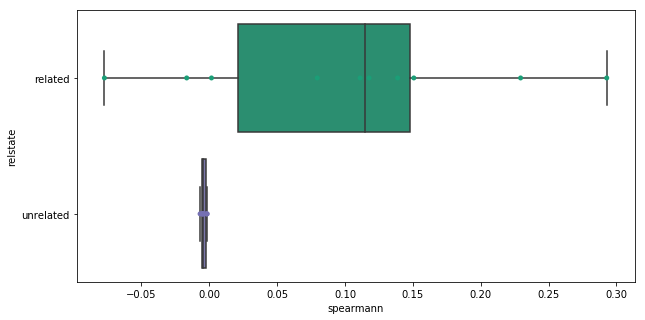

In [30]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (10.0, 5.0)
pltdf = pd.DataFrame(index=list(corrpd.index)*2, columns=['spearmann', 'relstate'])
pltdf.spearmann = list(corrpd.related_corr) + list(corrpd.unrelated_corr)
pltdf.relstate = ['related']*len(list(corrpd.related_corr)) + ['unrelated']*len(list(corrpd.unrelated_corr))



sns.boxplot(x='spearmann', y='relstate', data=pltdf, palette={'related':'#1b9e77', 
                                                              'unrelated':'#7570b3'})
sns.stripplot(x='spearmann', y='relstate', data=pltdf, jitter=False, 
              palette={'related':'#1b9e77', 'unrelated':'#7570b3'})
plt.savefig('figures/fig1a.spearmann_phylum.pdf', bbox_to_inches='tight')

In [31]:
from scipy.stats import kruskal
# test of significance between related and unrelated correlations
kruskal(corrpd.related_corr, corrpd.unrelated_corr)

KruskalResult(statistic=5.1428571428571388, pvalue=0.023342202012890959)

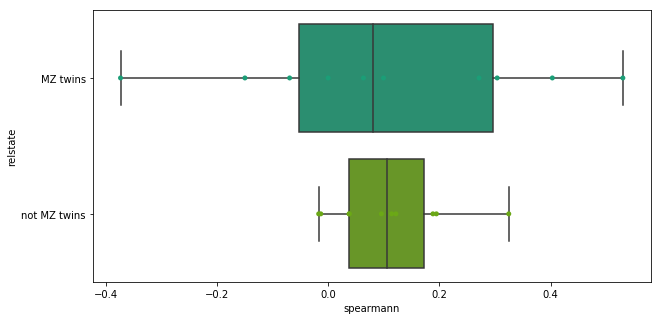

In [32]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (10.0, 5.0)
pltdf = pd.DataFrame(index=list(corrpd.index)*2, columns=['spearmann', 'relstate'])
pltdf.spearmann = list(corrpd.mz_corr) + list(corrpd.not_mz_corr)
pltdf.relstate = ['MZ twins']*len(list(corrpd.mz_corr)) + ['not MZ twins']*len(list(corrpd.not_mz_corr))



sns.boxplot(x='spearmann', y='relstate', data=pltdf, palette={'MZ twins':'#1b9e77', 'not MZ twins': '#6ba816'})
sns.stripplot(x='spearmann', y='relstate', data=pltdf, jitter=False, 
              palette={'MZ twins':'#1b9e77', 'not MZ twins': '#6ba816'})
plt.savefig('figures/fig1a.spearmann_phylum_R1.pdf', bbox_to_inches='tight')

In [33]:
# test of significance between mz and not mz relatives
kruskal(corrpd.mz_corr, corrpd.not_mz_corr)

KruskalResult(statistic=0.0057142857142764569, pvalue=0.93974298957712199)

### 2b. correlations @ 16S level

In [34]:
table = biom.load_table('freference-hit9k-wtax.biom')
tablepd = pd.read_table('freference-hit9k-wtax.txt', sep='\t',skiprows=1, index_col=0)
sample_arr = table.ids('sample')
otu_arr = table.ids('observation')

In [35]:
relcorr = []
relp = []

mzcorr = []
mzp = []

nmzcorr = []
nmzp = []

urelcorr = []
urelp=[]

for idx in tablepd.index:
    
    #overall related
    rpv1 = np.array(tablepd.loc[idx, rp1])
    rpv2 = np.array(tablepd.loc[idx, rp2])
    corr = spearmanr(rpv1, rpv2)
    relcorr.append(corr.correlation)
    relp.append(corr.pvalue)
    
    #monozygotic
    mzv1 = np.array(tablepd.loc[idx, mzp1])
    mzv2 = np.array(tablepd.loc[idx, mzp2])
    corr = spearmanr(mzv1, mzv2)
    mzcorr.append(corr.correlation)
    mzp.append(corr.pvalue)
    
    #dizygotic
    nmzv1 = np.array(tablepd.loc[idx, nmzp1])
    nmzv2 = np.array(tablepd.loc[idx, nmzp2])
    corr = spearmanr(nmzv1, nmzv2)
    nmzcorr.append(corr.correlation)
    nmzp.append(corr.pvalue)
    
    #unrelated 
    urpv1 = np.array(tablepd.loc[idx, urp1])
    urpv2 = np.array(tablepd.loc[idx, urp2])
    corr = spearmanr(urpv1, urpv2)
    urelcorr.append(corr.correlation)
    urelp.append(corr.pvalue)

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [36]:
corrpd = pd.DataFrame(index=tablepd.index, columns=['related_corr', 'related_pval', 
                                                    'unrelated_corr', 'unrelated_pval', 
                                                    'mz_corr', 'mz_pval', 
                                                    'not_mz_corr', 'not_mz_pval'])
corrpd.related_corr =  relcorr
corrpd.related_pval =  relp
corrpd.unrelated_corr =  urelcorr
corrpd.unrelated_pval =  urelp

corrpd.mz_corr =  mzcorr
corrpd.mz_pval =  mzp
corrpd.not_mz_corr =  nmzcorr
corrpd.not_mz_pval =  nmzp
corrpd.to_csv('tables/source_data_fig1b.csv', sep=',')

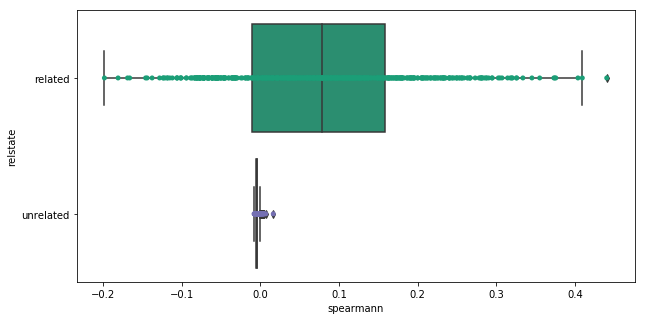

In [37]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (10.0, 5.0)
pltdf = pd.DataFrame(index=list(corrpd.index)*2, columns=['spearmann', 'relstate'])
pltdf.spearmann = list(corrpd.related_corr) + list(corrpd.unrelated_corr)
pltdf.relstate = ['related']*len(list(corrpd.related_corr)) + ['unrelated']*len(list(corrpd.unrelated_corr))

sns.boxplot(x='spearmann', y='relstate', data=pltdf, palette={'related':'#1b9e77', 
                                                              'unrelated':'#7570b3'})
sns.stripplot(x='spearmann', y='relstate', data=pltdf, jitter=False, color='k', 
              palette={'related':'#1b9e77', 'unrelated':'#7570b3'})
plt.savefig('figures/fig1b.spearmann_16S.pdf', bbox_to_inches='tight')

In [38]:
from scipy.stats import kruskal

corrpd = corrpd.dropna(axis=0)
kruskal(corrpd.related_corr, corrpd.unrelated_corr)

KruskalResult(statistic=178.41370431362563, pvalue=1.0759233164885877e-40)

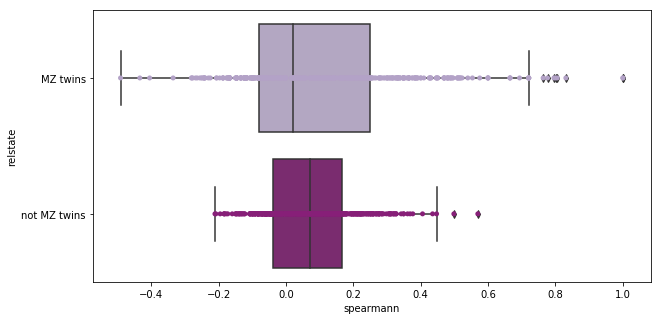

In [39]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (10.0, 5.0)
pltdf = pd.DataFrame(index=list(corrpd.index)*2, columns=['spearmann', 'relstate'])
pltdf.spearmann = list(corrpd.mz_corr) + list(corrpd.not_mz_corr)
pltdf.relstate = ['MZ twins']*len(list(corrpd.mz_corr)) + ['not MZ twins']*len(list(corrpd.not_mz_corr))



sns.boxplot(x='spearmann', y='relstate', data=pltdf, palette={'MZ twins':'#B3A2C7', 'not MZ twins': '#871F78'})
sns.stripplot(x='spearmann', y='relstate', data=pltdf, jitter=False, 
              palette={'MZ twins':'#B3A2C7', 'not MZ twins': '#871F78'})
plt.savefig('figures/fig1a.spearmann_16S_R1.pdf', bbox_to_inches='tight')

In [40]:
# test of significance between mz and not mz relatives
kruskal(corrpd.mz_corr, corrpd.not_mz_corr)

KruskalResult(statistic=1.3361998551931396, pvalue=0.24770524480558354)

### 2c. add taxonomy for 16S correlation table

In [41]:
corr = pd.read_table('tables/source_data_fig1b.csv', sep=',', index_col=0)
taxa = pd.read_table('taxonomy.txt', sep='\t', index_col=0)
taxa2 = taxa[['taxonomy']]

In [42]:
# add taxonomy to correlation table
corr['taxonomy'] = [taxa2.loc[idx, 'taxonomy'] for idx in corr.index]

In [43]:
#create empty table
corr2 = pd.DataFrame(index=corr.index, columns=list(corr.columns)+
                     ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'])

# add levels of taxonomy to new table
for idx in corr.index:
    data = (corr.loc[idx, 'taxonomy']).split('; ')
    
    diff = 7 - len(data)
    data = data + [np.nan]*diff
    
    corr2.loc[idx] = corr.loc[idx].append(pd.Series(data, 
                                   index=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']))

In [44]:
corr2.to_csv('tables/source_data_fig1b_wtaxonomy.csv', sep=',')